In [ ]:
import cv2
import numpy as np 

from getFeatures import getFeatures
from estimateAllTranslation import estimateAllTranslation
from applyGeometricTransformation import applyGeometricTransformation


def objectTracking(rawVideo, draw_bb=False, play_realtime=False, save_to_file=False):
    # initilize
    n_frame = 400
    frames = np.empty((n_frame,),dtype=np.ndarray)
    frames_draw = np.empty((n_frame,),dtype=np.ndarray)
    bboxs = np.empty((n_frame,),dtype=np.ndarray)
    for frame_idx in range(n_frame):
        _, frames[frame_idx] = rawVideo.read()

    # draw rectangle roi for target objects, or use default objects initilization
    if draw_bb:
        n_object = int(input("Number of objects to track:"))
        bboxs[0] = np.empty((n_object,4,2), dtype=float)
        for i in range(n_object):
            (xmin, ymin, boxw, boxh) = cv2.selectROI("Select Object %d"%(i),frames[0])
            cv2.destroyWindow("Select Object %d"%(i))
            bboxs[0][i,:,:] = np.array([[xmin,ymin],[xmin+boxw,ymin],[xmin,ymin+boxh],[xmin+boxw,ymin+boxh]]).astype(float)
    else:
        n_object = 1
        bboxs[0] = np.array([[[291,187],[405,187],[291,267],[405,267]]]).astype(float)
    
    if save_to_file:
        out = cv2.VideoWriter('output.avi',0,cv2.VideoWriter_fourcc('M','J','P','G'),20.0,(frames[i].shape[1],frames[i].shape[0]))
    
    # Start from the first frame, do optical flow for every two consecutive frames.
    startXs,startYs = getFeatures(cv2.cvtColor(frames[0],cv2.COLOR_RGB2GRAY),bboxs[0],use_shi=False)
    for i in range(1,n_frame):
        print('Processing Frame',i)
        newXs, newYs = estimateAllTranslation(startXs, startYs, frames[i-1], frames[i])
        Xs, Ys ,bboxs[i] = applyGeometricTransformation(startXs, startYs, newXs, newYs, bboxs[i-1])
        
        # update coordinates
        startXs = Xs
        startYs = Ys

        # update feature points as required
        n_features_left = np.sum(Xs!=-1)
        print('# of Features: %d'%n_features_left)
        if n_features_left < 15:
            print('Generate New Features')
            startXs,startYs = getFeatures(cv2.cvtColor(frames[i],cv2.COLOR_RGB2GRAY),bboxs[i])

        # draw bounding box and visualize feature point for each object
        frames_draw[i] = frames[i].copy()
        for j in range(n_object):
            (xmin, ymin, boxw, boxh) = cv2.boundingRect(bboxs[i][j,:,:].astype(int))
            frames_draw[i] = cv2.rectangle(frames_draw[i], (xmin,ymin), (xmin+boxw,ymin+boxh), (255,0,0), 2)
            for k in range(startXs.shape[0]):
                frames_draw[i] = cv2.circle(frames_draw[i], (int(startXs[k,j]),int(startYs[k,j])),3,(0,0,255),thickness=2)
        
        # imshow if to play the result in real time
        if play_realtime:
            cv2.imshow("win",frames_draw[i])
            cv2.waitKey(10)
        if save_to_file:
            out.write(frames_draw[i])
    
    if save_to_file:
        out.release()

if __name__ == "__main__":
    cap = cv2.VideoCapture("track1.mp4")
    objectTracking(cap,draw_bb=True,play_realtime=True,save_to_file=True)
    cap.release()

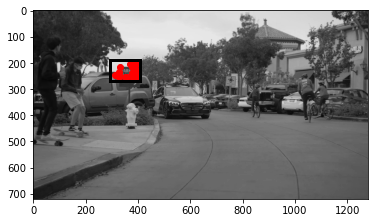

In [1]:
import cv2
import numpy as np
from skimage.feature import corner_harris, corner_shi_tomasi, peak_local_max

def getFeatures(img,bbox,use_shi=False):
    n_object = np.shape(bbox)[0]
    N = 0
    temp = np.empty((n_object,),dtype=np.ndarray)   # temporary storage of x,y coordinates
    for i in range(n_object):
        (xmin, ymin, boxw, boxh) = cv2.boundingRect(bbox[i,:,:].astype(int))
        roi = img[ymin:ymin+boxh,xmin:xmin+boxw]
        # cv2.imshow('roi',roi)
        if use_shi:
            corner_response = corner_shi_tomasi(roi)
        else:
            corner_response = corner_harris(roi)
        coordinates = peak_local_max(corner_response,num_peaks=20,exclude_border=2)
        coordinates[:,1] += xmin
        coordinates[:,0] += ymin
        temp[i] = coordinates
        if coordinates.shape[0] > N:
            N = coordinates.shape[0]
    x = np.full((N,n_object),-1)
    y = np.full((N,n_object),-1)
    for i in range(n_object):
        n_feature = temp[i].shape[0]
        x[0:n_feature,i] = temp[i][:,1]
        y[0:n_feature,i] = temp[i][:,0]
    return x,y

if __name__ == "__main__":
    cap = cv2.VideoCapture("track1.mp4")
    ret, frame = cap.read()  # get first frame

    # This section is for generating bounding boxes
    # n_object =  int(input("Number of objects to track:"))
    # bbox = np.empty((n_object,4,2), dtype=int)
    # for i in range(n_object):
    #     (xmin, ymin, boxw, boxh) = cv2.selectROI("Select Object %d"%(i),frame)
    #     cv2.destroyWindow("Select Object %d"%(i))
    #     bbox[i,:,:] = np.array([[xmin,ymin],[xmin+boxw,ymin],[xmin,ymin+boxh],[xmin+boxw,ymin+boxh]])

    # We can use fixed
    n_object = 1
    bbox = np.array([[[291,187],[405,187],[291,267],[405,267]]])

    frame_gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
    x,y = getFeatures(frame_gray,bbox)

    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots()
    ax.imshow(frame_gray,cmap='gray')
    ax.scatter(x[x!=-1],y[y!=-1],color=(1,0,0))
    for i in range(n_object):
        (xmin, ymin, boxw, boxh) = cv2.boundingRect(bbox[i,:,:])
        patch = Rectangle((xmin,ymin),boxw,boxh,fill=False,color=(0,0,0),linewidth=3)
        ax.add_patch(patch)
    plt.show()

too few points


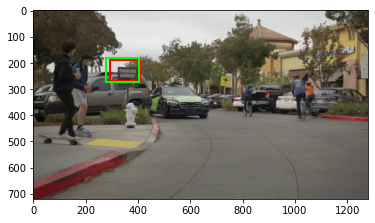

In [2]:
import cv2
import numpy as np
from skimage import transform as tf

def applyGeometricTransformation(startXs, startYs, newXs, newYs, bbox):
    n_object = bbox.shape[0]
    newbbox = np.zeros_like(bbox)
    Xs = newXs.copy()
    Ys = newYs.copy()
    for obj_idx in range(n_object):
        startXs_obj = startXs[:,[obj_idx]]
        startYs_obj = startYs[:,[obj_idx]]
        newXs_obj = newXs[:,[obj_idx]]
        newYs_obj = newYs[:,[obj_idx]]
        desired_points = np.hstack((startXs_obj,startYs_obj))
        actual_points = np.hstack((newXs_obj,newYs_obj))
        t = tf.SimilarityTransform()
        t.estimate(dst=actual_points, src=desired_points)
        mat = t.params

        # estimate the new bounding box with all the feature points
        # coords = np.vstack((bbox[obj_idx,:,:].T,np.array([1,1,1,1])))
        # new_coords = mat.dot(coords)
        # newbbox[obj_idx,:,:] = new_coords[0:2,:].T

        # estimate the new bounding box with only the inliners (Added by Yongyi Wang)
        THRES = 1
        projected = mat.dot(np.vstack((desired_points.T.astype(float),np.ones([1,np.shape(desired_points)[0]]))))
        distance = np.square(projected[0:2,:].T - actual_points).sum(axis = 1)
        actual_inliers = actual_points[distance < THRES]
        desired_inliers = desired_points[distance < THRES]
        if np.shape(desired_inliers)[0]<4:
            print('too few points')
            actual_inliers = actual_points
            desired_inliers = desired_points
        t.estimate(dst=actual_inliers, src=desired_inliers)
        mat = t.params
        coords = np.vstack((bbox[obj_idx,:,:].T,np.array([1,1,1,1])))
        new_coords = mat.dot(coords)
        newbbox[obj_idx,:,:] = new_coords[0:2,:].T
        Xs[distance >= THRES, obj_idx] = -1
        Ys[distance >= THRES, obj_idx] = -1

    return Xs, Ys, newbbox

if __name__ == "__main__":
    from getFeatures import getFeatures
    from estimateAllTranslation import estimateAllTranslation

    cap = cv2.VideoCapture("track1.mp4")
    ret, frame1 = cap.read()  # get first frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    frame1_gray = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
    frame2_gray = cv2.cvtColor(frame2,cv2.COLOR_RGB2GRAY)

   
    # This section is for generating bounding boxes
    # n_object = int(input("Number of objects to track:"))
    # bbox = np.empty((n_object,4,2), dtype=int)
    # for i in range(n_object):
    #     (xmin, ymin, boxw, boxh) = cv2.selectROI("Select Object %d"%(i),frame1)
    #     cv2.destroyWindow("Select Object %d"%(i))
    #     bbox[i,:,:] = np.array([[xmin,ymin],[xmin+boxw,ymin],[xmin,ymin+boxh],[xmin+boxw,ymin+boxh]])

    # We can use fixed
    n_object = 1
    bbox = np.array([[[291,187],[405,187],[291,267],[405,267]]]).astype(float)

    startXs,startYs = getFeatures(frame1_gray,bbox)
    newXs, newYs =  estimateAllTranslation(startXs, startYs, frame1, frame2)
    Xs, Ys ,newbbox = applyGeometricTransformation(startXs, startYs, newXs, newYs, bbox)


    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots()

    diff = np.subtract(frame1_gray.astype(int),frame2_gray.astype(int))
    ax.imshow(cv2.cvtColor(frame2,cv2.COLOR_BGR2RGB))
    # ax.scatter(newXs[newXs!=-1],newYs[newYs!=-1],color=(0,1,0))
    # ax.scatter(startXs[startXs!=-1],startYs[startYs!=-1],color=(1,0,0))

    for i in range(n_object):
        (xmin, ymin, boxw, boxh) = cv2.boundingRect(bbox[i,:,:].astype(int))
        patch = Rectangle((xmin,ymin),boxw,boxh,fill=False,color=(1,0,0),linewidth=2)
        ax.add_patch(patch)
        (xmin, ymin, boxw, boxh) = cv2.boundingRect(newbbox[i,:,:].astype(int))
        patch = Rectangle((xmin,ymin),boxw,boxh,fill=False,color=(0,1,0),linewidth=2)
        ax.add_patch(patch)
    plt.show()

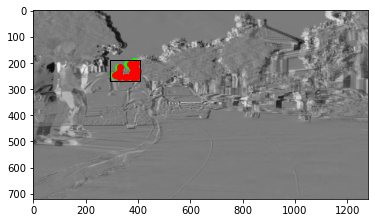

In [3]:
import numpy as np
import cv2
from scipy import signal

from getFeatures import getFeatures
from estimateFeatureTranslation import estimateFeatureTranslation

def estimateAllTranslation(startXs,startYs,img1,img2):
    I = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    I = cv2.GaussianBlur(I,(5,5),0.2)
    Iy, Ix = np.gradient(I.astype(float))

    startXs_flat = startXs.flatten()
    startYs_flat = startYs.flatten()
    newXs = np.full(startXs_flat.shape,-1,dtype=float)
    newYs = np.full(startYs_flat.shape,-1,dtype=float)
    for i in range(np.size(startXs)):
        if startXs_flat[i] != -1:
            newXs[i], newYs[i] = estimateFeatureTranslation(startXs_flat[i], startYs_flat[i], Ix, Iy, img1, img2)
    newXs = np.reshape(newXs, startXs.shape)
    newYs = np.reshape(newYs, startYs.shape)
    return newXs, newYs

if __name__ == "__main__":
    cap = cv2.VideoCapture("track1.mp4")
    ret, frame1 = cap.read()  # get first frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    ret, frame2 = cap.read()  # get second frame
    frame1_gray = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
    frame2_gray = cv2.cvtColor(frame2,cv2.COLOR_RGB2GRAY)

    n_object = 1
    bbox = np.array([[[291,187],[405,187],[291,267],[405,267]]])

    startXs,startYs = getFeatures(frame1_gray,bbox)
    newXs, newYs =  estimateAllTranslation(startXs, startYs, frame1, frame2)

    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots()
    diff = np.subtract(frame1_gray.astype(int),frame2_gray.astype(int))
    ax.imshow(diff,cmap='gray')
    ax.scatter(newXs[newXs!=-1],newYs[newYs!=-1],color=(0,1,0))
    ax.scatter(startXs[startXs!=-1],startYs[startYs!=-1],color=(1,0,0))
    for i in range(n_object):
        (xmin, ymin, boxw, boxh) = cv2.boundingRect(bbox[i,:,:])
        patch = Rectangle((xmin,ymin),boxw,boxh,fill=False,color=(0,0,0),linewidth=1)
        ax.add_patch(patch)
    plt.show()

In [4]:
import numpy as np
from numpy.linalg import inv
import cv2
from utils import interp2

WINDOW_SIZE = 25

def estimateFeatureTranslation(startX,startY,Ix,Iy,img1,img2):
    X=startX
    Y=startY
    mesh_x,mesh_y=np.meshgrid(np.arange(WINDOW_SIZE),np.arange(WINDOW_SIZE))
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    mesh_x_flat_fix =mesh_x.flatten() + X - np.floor(WINDOW_SIZE / 2)
    mesh_y_flat_fix =mesh_y.flatten() + Y - np.floor(WINDOW_SIZE / 2)
    coor_fix = np.vstack((mesh_x_flat_fix,mesh_y_flat_fix))
    I1_value = interp2(img1_gray, coor_fix[[0],:], coor_fix[[1],:])
    Ix_value = interp2(Ix, coor_fix[[0],:], coor_fix[[1],:])
    Iy_value = interp2(Iy, coor_fix[[0],:], coor_fix[[1],:])
    I=np.vstack((Ix_value,Iy_value))
    A=I.dot(I.T)
   

    for _ in range(15):
        mesh_x_flat=mesh_x.flatten() + X - np.floor(WINDOW_SIZE / 2)
        mesh_y_flat=mesh_y.flatten() + Y - np.floor(WINDOW_SIZE / 2)
        coor=np.vstack((mesh_x_flat,mesh_y_flat))
        I2_value = interp2(img2_gray, coor[[0],:], coor[[1],:])
        Ip=(I2_value-I1_value).reshape((-1,1))
        b=-I.dot(Ip)
        solution=inv(A).dot(b)
        # solution = np.linalg.solve(A, b)
        X += solution[0,0]
        Y += solution[1,0]
    
    return X, Y